In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import re
import itertools
import time
import joblib
import random

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, auc, roc_curve
from sklearn import svm, ensemble, datasets

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.75

In [5]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']
indices = dict((c, i) for i, c in enumerate(callers))

In [8]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [9]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [10]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [11]:
training_data = [apps.assemble_data(sample, callers, out_dir) for sample in training_samples]
#training_data = [apps.assemble_data(sample, callers, out_dir) for sample in samples]

In [12]:
start = time.time()
X_train = np.array(sum([data.result()[0] for data in training_data], []))
Y_train = np.array(sum([data.result()[1] for data in training_data], []))
np.save('X_train.npy', X_train)
np.save('Y_train.npy', Y_train)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 31.9s


In [13]:
X_train.shape, caller_data.shape

((53013, 5), (218107, 8))

In [66]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)
classifiers = []
for features in [
            ['pizzly', 'starseqr', 'fusioncatcher'],
            ['pizzly', 'starfusion', 'arriba', 'fusioncatcher'],
            callers,
            #['arriba']
            #['STARSEQR', 'PIZZLY', 'PRADA', 'FUSIONCATCHER_v1.10_June192019', 'ChimeraScan', 'ARRIBA', 'MapSplice'],
            #['STARSEQR', 'PIZZLY', 'PRADA', 'FUSIONCATCHER_v1.10_June192019', 'ChimeraScan', 'ARRIBA', 'MapSplice', 'STAR_FUSION_v1.5'],
            #['STARSEQR', 'ARRIBA', 'STAR_FUSION_v1.5']
        ]:
    
    pruned_indices = [indices[f] for f in features]
    
    label = 'SVC{}Features'.format(len(features))
    svc_trans = 'flatten'
    svc = svm.LinearSVC()
    svc.fit(getattr(transformations, svc_trans)(X_train[:, pruned_indices]), Y_train)
    joblib.dump(svc, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(label, pruned_indices, svc_trans)]
    
    label = 'RFC{}Features'.format(len(features))
    rfc_trans = 'noop'
    rfc = ensemble.RandomForestClassifier()
    rfc.fit(getattr(transformations, rfc_trans)(X_train[:, pruned_indices]), Y_train)
    joblib.dump(rfc, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(label, pruned_indices, rfc_trans)]
    
    label = 'GBC{}Features'.format(len(features))
    gbc_trans = 'noop'
    gbc = ensemble.GradientBoostingClassifier()
    gbc.fit(getattr(transformations, rfc_trans)(X_train[:, pruned_indices]), Y_train)
    joblib.dump(gbc, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(label, pruned_indices, gbc_trans)]
    
print('fit models in {:.1f}s'.format((time.time() - start)))

fit models in 35.7s


In [67]:
X_train.shape, sum(Y_train)

((53013, 5), 27992)

In [68]:
testing_data = [apps.assemble_data(sample, callers, out_dir) for sample in testing_samples]

In [69]:
start = time.time()
X_test = np.array(sum([data.result()[0] for data in testing_data], []))
Y_test = np.array(sum([data.result()[1] for data in testing_data], []))

print('assembled testing data in {:.1f}s'.format((time.time() - start)))

assembled testing data in 15.7s


In [70]:
X_test.shape, Y_test.shape

((18558, 5), (18558,))

In [71]:
start = time.time()
futures = []
for sample in testing_samples:
    for label, feature_indices, transformation in classifiers:
        futures += [apps.predict(sample, out_dir, label, feature_indices, transformation, callers)]
#futures = [apps.predict(sample, out_dir, classifiers, callers) for sample in testing_samples]
polyfuse_data = pd.concat([f.result() for f in futures])
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled predictions in 92.9s


In [72]:
polyfuse_data.to_hdf(os.path.join(out_dir, 'polyfuse_data.hdf'), 'data', mode='w')

/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->['spanning_reads', 'junction_reads', 'sample', 'caller', 'gene1', 'gene2', 'fusion', 'sum_J_S']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [73]:
start = time.time()
truth_path = os.path.join(out_dir, 'true_fusions.hdf')
futures = [apps.score(sample, os.path.join(out_dir, 'polyfuse_data.hdf'), truth_path) for sample in testing_samples]
futures += [apps.score(sample, os.path.join(out_dir, 'caller_data.hdf'), truth_path) for sample in testing_samples]
#summary = pd.concat([f.result() for f in futures])
print('assembled scores in {:.1f}s'.format((time.time() - start)))

assembled scores in 0.1s


In [74]:
summary = pd.concat([f.result() for f in futures])

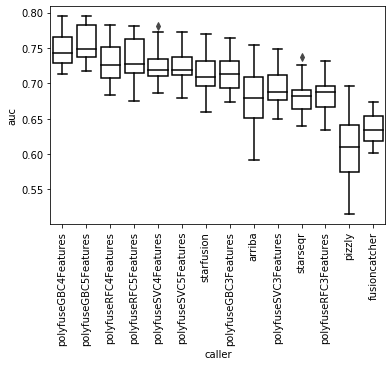

In [75]:
#ax = sns.boxplot(x="caller", y="average PR", data=summary)
ax = sns.boxplot(x="caller", y="auc", data=summary.sort_values(by='auc', ascending=False))
labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
_ = plt.setp(ax.lines, color='k')
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/auc_RFC_SVC_3-7-8-23_features_sum_J_S.pdf')

In [76]:
pd.options.display.max_rows = None
summary.sort_values(by='auc', ascending=False)

,sample,caller,auc,average PR,total FP,total FN,total TP
0,LIB-04650wt,polyfuseGBC4Features,0.794791,0.926899,47,72,428
0,LIB-04650wt,polyfuseGBC5Features,0.794605,0.923105,47,70,430
0,LIB-04655wt,polyfuseGBC4Features,0.791218,0.933604,41,77,423
0,LIB-04657wt,polyfuseGBC5Features,0.789752,0.925934,37,73,427
0,LIB-04642wt,polyfuseGBC5Features,0.788062,0.938718,38,81,419
0,LIB-04657wt,polyfuseGBC4Features,0.786112,0.923913,38,74,426
0,LIB-04655wt,polyfuseGBC5Features,0.786036,0.926093,43,76,424
0,LIB-04646wt,polyfuseGBC5Features,0.782694,0.919342,44,74,426
0,LIB-04650wt,polyfuseRFC4Features,0.782416,0.917821,49,74,426
0,LIB-04653wt,polyfuseGBC5Features,0.782356,0.924485,29,75,425


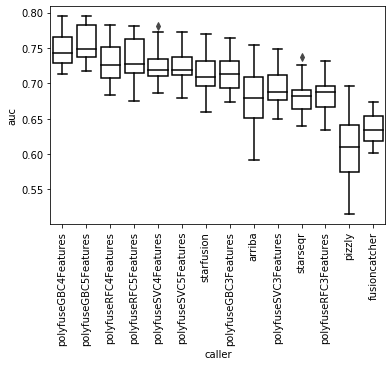

In [77]:
#ax = sns.boxplot(x="caller", y="average PR", data=summary)
ax = sns.boxplot(x="caller", y="auc", data=summary.sort_values(by='auc', ascending=False))
labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
_ = plt.setp(ax.lines, color='k')
#plt.savefig('plots/auc_RFC_SVC_3-7-8-23_features.pdf')

In [78]:
pd.options.display.max_rows = None
summary.sort_values(by='auc', ascending=False)

,sample,caller,auc,average PR,total FP,total FN,total TP
0,LIB-04650wt,polyfuseGBC4Features,0.794791,0.926899,47,72,428
0,LIB-04650wt,polyfuseGBC5Features,0.794605,0.923105,47,70,430
0,LIB-04655wt,polyfuseGBC4Features,0.791218,0.933604,41,77,423
0,LIB-04657wt,polyfuseGBC5Features,0.789752,0.925934,37,73,427
0,LIB-04642wt,polyfuseGBC5Features,0.788062,0.938718,38,81,419
0,LIB-04657wt,polyfuseGBC4Features,0.786112,0.923913,38,74,426
0,LIB-04655wt,polyfuseGBC5Features,0.786036,0.926093,43,76,424
0,LIB-04646wt,polyfuseGBC5Features,0.782694,0.919342,44,74,426
0,LIB-04650wt,polyfuseRFC4Features,0.782416,0.917821,49,74,426
0,LIB-04653wt,polyfuseGBC5Features,0.782356,0.924485,29,75,425
